In [39]:
from IPython.display import HTML
HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

# Proposal: Develop Business for House Leasing Online Platform

# Abstract

After second though, I decide to present the task as a pitch for the potential client, hope that works for this task. All the questions in the task will be answered in different sections below. So suppose we're now pitching to a client who does business on matching up rentor to landlord online. With the information gained from Shanghai transportation records, what can we do to further enhance and expand the client's business in Shanghai?

## Picture an Application Scenario

> Imagine our online flat leasing company would like to find out the most suitable subway stations to launch its ads, making most use of the budget and reaching the passengers who are most likely-to-be its customers. Furthermore, once we get the attention from them and direct them to our online platform, what additional information can we provide to further enhance their experience interacting with the platform?

<mark>**Expected Outcome**</mark><br/>

In order to answer the problem mentioned above, first I will identify the stations which have the highest share of long distance commuters, for these passengers would be most likely to be attracted by the flat ads at the station. Secondly, in their journey interacting with our platform, we can offer more flexible search methods for them to find out their favorite flat choices. One idea is to enable them to search based on the **expected commute time**. Lastly, the filter can be delved further to present the expected commute time over each hour within a day. This information will greatly benefit them in choosing appropriate flats, as they can now assess what' the best timing they should leave from home for office.

<mark>**Actual Analysis Outcome**</mark>

Let me quickly summarize the result in advance. By the end of this analysis, I am able to come up with a list of suggested stations for ads placement. Adhering  to the stations, I also obtain a table of expected commute time for various subway routes. Nonetheless, from the data exploration, I find there is no difference of commute time among hours on which passengers choose to take subway. But it's something await to be further investigated and confirmed. Noted that in this analysis, it will mostly be statistic summary, less of modeling, as I figure the statistics contain more business insights and values compared to modeling. Nonetheless, I do include a proposal for feature engineering and modeling under the condition if additional data are provided.

## Structure of The Report

<mark>**1. Data Processing**</mark><br/>

In this section, practices include implementing sampling on original dataset, having data validation, and splitting out the subway data alone for later use.

<mark>**2. Data Exploration on Subway Transportation Records**</mark><br/>

I will find out what stations have the largest traffic volume, and what's the average commute time per subway trip.

<mark>**3. Identify Best Stations for Ads Launch**</mark><br/>

In this section, I will come up with a list of suggested stations for ads placement.

<mark>**4. Get the Table of Expected Commute Time for each Route**</mark><br/>

In the beginning, I will delve further to find commute time among different time slot. However, facing the limitation of fewer samples owing to sampling, I will just split the time slot into peak and off-peak hour. Then discuss if there shows difference of commute time between two time slots. If there is no difference of commute time between time slots. Then, I will just simplify the result dataset and compute the expected commute time for each route regardless of the timing to take subway.

<mark>**5. Empower with more Additional Data**</mark><br/>

In this section, I would discuss what are other suitable data to be collected and joined together. How these data will empower our flat leasing company even more? Let's say, our online flat leasing website already obtain each flat's rent, conditions etc, along with this traffic dataset. We can build up a rent prediction model out of these features.

<mark>**6. Proposed Model to be Used and in What Way**</mark><br/>

I will propose a hypothetical model that can predict the rent of the flat for newly landlord, based on the flat's location and other flat's conditions. This will be mostly helpful for the landlord, especially in some regions where there is little information of rent for reference. This section includes sketch of the model, what features to be considered and what models are appropriate in this case.

<mark>**7. Other Applications from this Dataset**</mark><br/>

In this final section, I will propose another application that this dataset is suitable to be used for. For instance, the traffic control of Shanghai Metro System.

So, without further delay, let me begin today's exploration.

# Preprocess Data

## Read in Raw Data

In [1]:
# import necessary modules
import pandas as pd
import numpy as np
import missingno as msno
from tqdm import tqdm, tqdm_notebook

import re

import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号
sns.set_style('whitegrid',{'font.sans-serif':['SimHei','Arial']}) # 用来处理seaborn显示中文

pd.options.display.float_format = '{:.2f}'.format

from IPython.display import display

In [2]:
# Function to print bold text in print().
from IPython.display import Markdown, display

def printmd(string):
    """
    Ref: https://discuss.analyticsvidhya.com/t/how-to-make-a-text-bold-within-print-statement-in-ipython-notebook/14552
    """
    display(Markdown(string))

In [ ]:
# Read in dataset
dataset = pd.read_csv('../Playground-dataset/02-Mass-Transit-Analysis-Dataset/SPTCC-20160701.csv', 
                      encoding='gbk',
                      header=None,
                      names = ['transit_card_id','date','time',
                               'line_and_stop_name','method_of_transit','fare_collected','fare_type'],
                      index_col=False) # encoding for simplified chinese

# print('Data type of each column:\n')
# dataset.info()

## Implement Sampling

Since the original dataset is way too large, just for the efficiency of analysis later on, I will have it sampled and explore the result dataset afterwards. The sampling is conducted on **each passenger (from the transit_card_id), picking up one id out of every 25 ids.**

<mark>**Result**</mark><br/>

The original dataset contains 15,772,842 records, and the sampled dataset contains **630,163** recrods, roughly **96%** of the original dataset are dropped off in this analysis. This poses a problem when analysing the data in more granular level. Neverthelsee, it can be solved when re-run this anlaysis in larger scale and specify higher frquency of sampling.

In [ ]:
# Sort by card id and set it as index, for speeding up following sampling process.
dataset = dataset.sort_values(by='transit_card_id').set_index(keys='transit_card_id')

# Sampling based on transit_card_id.
card_ids = np.unique(dataset.index.values)

def sampling(df, ids, step=10):
    
    sub_df = pd.DataFrame()
    for i in tqdm_notebook(range(0, len(ids), step)):
        id_ = ids[i]
        sub = df[df.index == id_]
        sub_df = sub_df.append(sub)
    
    return sub_df

samples = sampling(df=dataset, ids=card_ids, step=25)

In [ ]:
# Save the sampled dataset.
pd.to_pickle(samples, '../Playground-dataset/02-Mass-Transit-Analysis-Dataset/samples.pickle')

In [3]:
# Reload the dataset.
samples = pd.read_pickle('../Playground-dataset/02-Mass-Transit-Analysis-Dataset/samples.pickle')
samples = samples.reset_index()

## Check out Missing Value

In [4]:
printmd('**If exist missing values:**\n')
print(samples.isnull().any())

# print('Show up the distribution of missing value over each column (marked as white lines for each record):')
# _ = msno.matrix(samples)

**If exist missing values:**


transit_card_id       False
date                  False
time                  False
line_and_stop_name    False
method_of_transit     False
fare_collected        False
fare_type             False
dtype: bool


## Check out for Duplicates

In [5]:
printmd('**If exist duplicated rows:** {}, **number of duplicated rows:** {}\n'.format(
    samples.duplicated().any(), samples.duplicated().sum()))

samples = samples.drop_duplicates()
printmd('**Rows after dropping off duplicates:** {}'.format(samples.shape[0]))

**If exist duplicated rows:** True, **number of duplicated rows:** 1


**Rows after dropping off duplicates:** 630162

## Convert Datetime

In [6]:
samples['datetime'] = samples.apply(lambda df: df['date'] + ' ' + df['time'], axis=1)
samples['datetime'] = pd.to_datetime(samples['datetime'], format='%Y-%m-%d %H:%M:%S')

samples = samples.drop(['date','time'], axis=1)

## Subset Dataset for Each Transportation Method

In [7]:
# Preview of values in method_of_transit and fare_type.
printmd('**Unique value for method_of_transit:**')
print(samples['method_of_transit'].unique())

printmd('\n**Unique value for fare_type:**')
print(samples['fare_type'].unique())

**Unique value for method_of_transit:**

['公交' '地铁' '出租' '轮渡' 'P+R停车场']



**Unique value for fare_type:**

['非优惠' '优惠' '无']


In [8]:
# Separate dataset into each transportation type.
subway = samples[samples['method_of_transit'] == '地铁'].sort_values(['transit_card_id','datetime']).reset_index(drop=True)
ferry = samples[samples['method_of_transit'] == '轮渡'].sort_values(['transit_card_id','datetime']).reset_index(drop=True)
taxi = samples[samples['method_of_transit'] == '出租'].sort_values(['transit_card_id','datetime']).reset_index(drop=True)
parking = samples[samples['method_of_transit'] == 'P+R停车场'].sort_values(['transit_card_id','datetime']).reset_index(drop=True)
bus = samples[samples['method_of_transit'] == '公交'].sort_values(['transit_card_id','datetime']).reset_index(drop=True)

# Explore on Subway Trip Records

In [9]:
printmd('**Size of Subway:**')
display(subway.shape)

printmd('**Preview of Subway:**')
display(subway.head())

**Size of Subway:**

(412196, 6)

**Preview of Subway:**

,transit_card_id,line_and_stop_name,method_of_transit,fare_collected,fare_type,datetime
0,59911,2号线静安寺,地铁,0.00,非优惠,2016-07-01 20:10:57
1,59911,8号线虹口足球场,地铁,4.00,非优惠,2016-07-01 20:36:52
2,68421,8号线芦恒路,地铁,0.00,非优惠,2016-07-01 07:41:04
3,68421,9号线打浦桥,地铁,4.00,非优惠,2016-07-01 08:11:48
4,68421,9号线打浦桥,地铁,0.00,非优惠,2016-07-01 15:26:27


## Clean up and Validate Quality in Data

As we saw from dataset above, every passenger will **leave two records** - entry and exit of subway station for one trip. Thus, I will implement the following steps to further ensure data quality and transform subway dataset into ready-for-use, clean data.

<mark>**Goal**</mark><br/>

Ensure each id has one *entry* record and corresponding one *exit* record. It will be checked by my self-defined functions `criterion()` and `df_concat()`.

<span style='margin:15px'>
    
1. I assume the entry record occurs in odd rows and has value 0 in *fare_collected* column over each id.
2. The exit record must follow immediately the entry record regardless what value it has in fare_collected column. The reasoning behind is that final fares can change due to various reasons, promotion, cash rewards etc. Thus, no need to examine the fare being collected.
3. Record that doesn't comply with the rules above will be removed from dataset.
4. The clean dataset for each id must have even rows (entry and exit pair-up) and eventually, join data of all id together as our final analysis dataset.
5. Split the *line* and *station name* from single column to separate columns.

</span>


<mark>**Result**</mark><br/>

- `Subway_clean` is ready for use in analysing traffic volume for each station.
- **8278** rows are being dropped off from subway dataset owing to the process above.

In [ ]:
# Drop off weird rows.
# criterion: The value of fare_collected in even index must be 0. 
#       if not, then remove the row and start examining the df all over again -> python is zero-based numbering
# df_concat: Only append df to the final dataset if df's size is even (2,4,6...etc) excluding 0.
#       if not, then drop off the last row and append remainging to final dataset.


def criterion(df):
    """ 
    @return
        df: can be shape of 0, 1, 2, 3, etc.
    """
    df.reset_index(drop=True, inplace=True)
    idx = 0
    max_idx = df.index.max()
    while True:
        if idx % 2 == 0: # for even index
            if df['fare_collected'][idx] != 0:
                df = df.drop(df.index[idx]) # remove the record
                df.reset_index(drop=True, inplace=True) # reset index
                if df.shape[0] == 0:
                    break # if df is null, then exit the loop
                else:
                    idx = 0 # loop from the beginning again
                    max_idx = df.index.max()
            else:
                idx += 1
        else: # for odd index
            idx += 1
        
        if idx >= max_idx:
            break
    return df
    
def df_concat(final_df, df):
    """
    @param
        final_df: final clean dataset
        df: the dataset to be appended to final_df
    @return
        final_df
    """
    
    if df.shape[0] % 2 == 0: # if df shape is 0 or even
        if df.shape[0] != 0: # if df shape is not 0
            final_df = final_df.append(df)
    else:
        if df.shape[0] != 1: # if df shape is not 1
            df = df.iloc[:-1, :] # drop off the last row
            final_df = final_df.append(df)
    return final_df

In [ ]:
# prepare the process status bar
iters = range(len(subway['transit_card_id'].unique()))

subway_clean = pd.DataFrame()

with tqdm_notebook(total=len(iters)) as pbar:
    for k1, group in subway.groupby(['transit_card_id']):
        group = criterion(group)
        subway_clean = df_concat(subway_clean, group)
        pbar.update(1)
    
# reset index
subway_clean.reset_index(drop=True, inplace=True)


In [ ]:
# split line number and station name
subway_clean['line_and_stop_name'] = subway_clean['line_and_stop_name'].str.strip() # stip string first
regex = re.compile('(\d+)号线(\w+)')
col = subway_clean['line_and_stop_name'].apply(lambda x: regex.search(x).group(1,2))
line, stop = map(np.array, zip(*col))
subway_clean['line'] = line
subway_clean['stop'] = stop
subway_clean.drop(labels=['line_and_stop_name'], axis=1, inplace=True)
print('Preview of subway_clean:')
display(subway_clean.head(n=2))

In [ ]:
# Preview of subway_clean
printmd('**Size of subway_clean:**')
display(subway_clean.shape)
printmd('**Preview of subway_clean:**')
display(subway_clean.head(n=8))

In [ ]:
# backup file
pd.to_pickle(subway_clean, '../Playground-dataset/02-Mass-Transit-Analysis-Dataset/subway_clean.pickle')

In [10]:
subway_clean = pd.read_pickle('../Playground-dataset/02-Mass-Transit-Analysis-Dataset/subway_clean.pickle')

## Stations with Largest Traffic

First, we can tell from the table below, the top stations with largest traffic volumn taking both entries and exits into account are:

<mark>**NOTED**</mark><br/>
This result comes from sampled dataset. The absolute values are under-estimated.

In [11]:
subway_clean = pd.read_pickle('../Playground-dataset/02-Mass-Transit-Analysis-Dataset/subway_clean.pickle')

In [ ]:
traffic_volumn = subway_clean.groupby(['line', 'stop']).count(
    )[['transit_card_id']].rename(columns={'transit_card_id':'traffic_volumn'}
                                 ).sort_values(by=['traffic_volumn'], ascending=False)

print('First 5 stations with largest traffic:')
display(traffic_volumn.head(n=5))

In [ ]:
# Plot station with largest traffic.
fig, ax = plt.subplots(1,1,figsize=(15,5))

_ = traffic_volumn.iloc[:10,:].plot.bar(y=['traffic_volumn'], ax=ax, rot=30, colors='#cec3c6')
_ = ax.legend(fontsize='x-large')
_ = ax.set_title('Stations of Largest Traffic', fontsize=20)
_ = ax.set_xlabel(xlabel='Line,Stations', fontsize=15)

## Average Subway Trip Length

### Prepare Dataset

Before compute the average trip length, let's transform the data again and create a new dataset `subway_trip` to record data in format of **per trip per row** for each id.

More specifically, each row will contain four columns: get-on station, time of get-on, get-off station, and time of get-off etc.

In [12]:
# prepare dataset for trip length
subway_trip_start = subway_clean[::2].reset_index(drop=True) # even row
subway_trip_start.columns = [col + '_x' for col in subway_trip_start.columns.values]
subway_trip_end = subway_clean[1::2].reset_index(drop=True) # odd row
subway_trip_end.columns = [col + '_y' for col in subway_trip_end.columns.values]

In [13]:
# Concatnate two dataset.
subway_trip = pd.concat([subway_trip_start, subway_trip_end], axis=1)
printmd('**Preview of subway_trip:**')
display(subway_trip[['transit_card_id_x','line_x','stop_x','datetime_x',
                    'line_y','stop_y','datetime_y']].head(n=3))

**Preview of subway_trip:**

,transit_card_id_x,line_x,stop_x,datetime_x,line_y,stop_y,datetime_y
0,59911,2,静安寺,2016-07-01 20:10:57,8,虹口足球场,2016-07-01 20:36:52
1,68421,8,芦恒路,2016-07-01 07:41:04,9,打浦桥,2016-07-01 08:11:48
2,68421,9,打浦桥,2016-07-01 15:26:27,8,芦恒路,2016-07-01 16:11:32


In [ ]:
# Save backup file.
pd.to_pickle(subway_trip, '../Playground-dataset/02-Mass-Transit-Analysis-Dataset/subway_trip.pickle')

### Find out Average Trip Length

<mark>**Result**</mark><br/>

We can tell that average subway tip length is roughly **43 mins**.

In [14]:
subway_trip = pd.read_pickle('../Playground-dataset/02-Mass-Transit-Analysis-Dataset/subway_trip.pickle')

In [15]:
# Compute trip length.
subway_trip['trip_length'] = subway_trip['datetime_y'] - subway_trip['datetime_x']

# Convert trip length to minutes integers.
subway_trip['trip_length'] = subway_trip['trip_length'].apply(lambda x: int(x.total_seconds()//60))

printmd('**Preview of trip_length:**')
display(subway_trip[['transit_card_id_x','line_x','stop_x','datetime_x',
                     'line_y','stop_y','datetime_y','trip_length']].head(n=5))
printmd('**Mean Trip Length:** {:.2f} mins'.format(subway_trip['trip_length'].mean()))

**Preview of trip_length:**

,transit_card_id_x,line_x,stop_x,datetime_x,line_y,stop_y,datetime_y,trip_length
0,59911,2,静安寺,2016-07-01 20:10:57,8,虹口足球场,2016-07-01 20:36:52,25
1,68421,8,芦恒路,2016-07-01 07:41:04,9,打浦桥,2016-07-01 08:11:48,30
2,68421,9,打浦桥,2016-07-01 15:26:27,8,芦恒路,2016-07-01 16:11:32,45
3,80212,4,南浦大桥,2016-07-01 18:22:12,4,宜山路,2016-07-01 18:42:30,20
4,85716,6,外高桥保税区南,2016-07-01 13:12:39,6,洲海路,2016-07-01 13:17:08,4


**Mean Trip Length:** 42.94 mins

# Identify Best Stations to Place Rent Ads

It's time to use the processed dataset to help us make practical decisions on marketing - outdoor ads launch in this case.

Over all 413 stations in Shanghai Metro, you'd probably want to know **which station has the highest share of long distance passengers**. For it will be most effective to place outdoor ads for flat leasing at these stations, for long distance passengers are definitely in need of flats of best price with least commute time.

## Distribution of Trip Length in The Morning

In the beginning, we need to filter on subway trip occurred in the morning (remaining 80,007 records). I just want to target the **morning commuters**, since they're most likely to be interested in finding new flats closer to the office. Thus, what's distribution like for morning trip length?

Form data shown on the graph below, trip length is extremely right-skewed, where the mean is **43 mins** and the median is **32 mins**.

In [16]:
# Subset trip occurs before 12pm.
subway_trip_mor = subway_trip[subway_trip['datetime_y'].apply(lambda x: x.hour < 12)]
print('Subway trips occurred in the moring: ', subway_trip_mor.shape[0])

Subway trips occurred in the moring:  80007


In [17]:
def plot_distribution(df, col, bins=15):
    
    fig, ax = plt.subplots(figsize=(15,5))
    sns.set_style(style='whitegrid')
    feature = df[col]
    sns.distplot(feature, bins=bins, hist=True, kde=True, ax=ax, color='#cec3c6')
    mean_line = ax.axvline(x=feature.mean(), linewidth=2, color='black', label='mean {:.2f}'.format(feature.mean()))
    median_line = ax.axvline(x=feature.median(), linewidth=2, color='red', label='median {:.2f}'.format(feature.median()))
    _ = ax.legend(handles=[mean_line, median_line])
    _ = ax.set_title('Histogram of {} for Bins = {}'.format(col, bins), fontsize='x-large')
    
    plt.show()

**Descriptive Statistics of Trip Length:**

,trip_length
count,80007.00
mean,35.69
std,21.08
min,0.00
25%,21.00
50%,32.00
75%,47.00
max,362.00


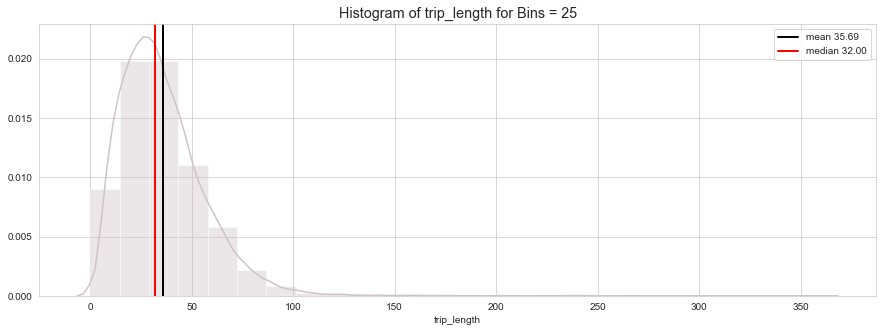

In [19]:
printmd('**Descriptive Statistics of Trip Length:**')
display(subway_trip_mor[['trip_length']].describe())

plot_distribution(df=subway_trip_mor, col='trip_length', bins=25)

## After Delete Outliers

It's obvious there are some outliers significantly dragging the distribution away, thus negatively influencing our interpretation. Let's remove them and observe the refined result, see if it improves.

After removing the outliers (3854 records deleted), we see the distribution is less right-skewed. Besides, from the histogram below, we know that most passengers' trip length span from **20 to 40 mins** (accounts more than half of all trips).

In [20]:
# Find outliers using IQR.
Q3 = float(subway_trip_mor['trip_length'].quantile([0.75]))
Q1 = float(subway_trip_mor['trip_length'].quantile([0.25]))
IQR = Q3 - Q1

high = Q3 + IQR
low = Q1 - IQR

subway_trip_mor_clean = subway_trip_mor[(low <= subway_trip_mor['trip_length']) & (subway_trip_mor['trip_length'] <= high)]
print('Outliers being deleted: {}'.format(subway_trip_mor.shape[0] - subway_trip_mor_clean.shape[0]))

Outliers being deleted: 3854


**Descriptive Statistics of Trip Length after Outliers Removed:**

,trip_length
count,76153.00
mean,32.87
std,16.31
min,0.00
25%,20.00
50%,31.00
75%,44.00
max,73.00


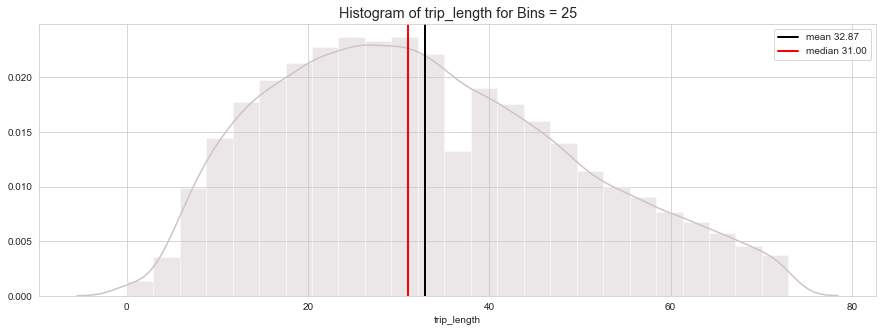

In [21]:
printmd('**Descriptive Statistics of Trip Length after Outliers Removed:**')
display(subway_trip_mor_clean[['trip_length']].describe())

plot_distribution(df=subway_trip_mor_clean, col='trip_length', bins=25)

## Classify Trips into Three Types

We're now familiar with the trip length distribution. Let's classify these trips into three types - short, medium, long distance. By classifying trips (and passengers behind) into different types, we can compute the share of each trip type in all stations, and identify which stations have the largest share of long distance passengers. These stations are the favorable ones to launch ads.

<mark>**Share of each Trip Type**</mark>

- Short distance trips (passengers) - Trip length less than 20 mins. (accounts for 26%)
- Medium distance trips (passengers) - Trip length from 20 to 60 mins. (accounts for 67%)
- Long distance trips (passengers) - Trip length longer than 60 mins. (accounts for 7%)

In [22]:
def bin_cut(df, col, bin_range):
    target_bin = pd.cut(df[col], bin_range, duplicates='drop') # drop off bins with the same index, incur less bin number

    print('Share of each bin:')
    bin_share = target_bin.groupby(target_bin).agg({'size': lambda x: x.size,
                                                    'share': lambda x: x.size/len(target_bin)})
    display(bin_share)

    map_class = {}
    for i, key in enumerate(sorted(target_bin.unique())):
        map_class[key] = i
    print('Bin and class label match:')
    display(map_class)

    target_bin_2 = target_bin.replace(map_class)
    target_bin = pd.concat([target_bin, target_bin_2], axis=1)
    target_bin.columns = ['{}_bin'.format(col), '{}_class'.format(col)]
    
    new_df = pd.concat([df, target_bin], axis=1)
    return new_df

In [23]:
subway_trip_mor_cl = bin_cut(
    df=subway_trip_mor_clean, 
    col='trip_length', 
    bin_range=[-1, 20, 60, subway_trip_mor['trip_length'].max()])

Share of each bin:


,size,share
trip_length,,
"(-1, 20]",19581,0.26
"(20, 60]",51401,0.67
"(60, 362]",5171,0.07


Bin and class label match:


{Interval(-1, 20, closed='right'): 0,
 Interval(20, 60, closed='right'): 1,
 Interval(60, 362, closed='right'): 2}

## Aggregate to Destination Station

Now I've classified each trip to short, medium, long distance trip. I can aggregate all trips up to station level, so that to see **the share of each trip type on each station.**

To be more precise here, the station in the context is the destination of each trip. What really matters is for each station, how long passengers have traveled to arrive that station, so that we know in which stations we're mostly likely to encounter long distance passengers.

In [24]:
# Count trip numbers.
station_share = subway_trip_mor_cl.groupby(['line_y','stop_y', 'trip_length_class']).count(
                    )[['trip_length_bin']].rename(columns={'trip_length_bin':'count'})

# long to wide
station_share = station_share.unstack(level='trip_length_class')

# remove multi-columns
cols = station_share.columns.droplevel()
cols = ['class_' + str(col) for col in cols]
station_share.columns = cols

In [25]:
# Calculate percentage.
station_share['total'] = station_share['class_0'] + station_share['class_1'] + station_share['class_2']
station_share['class_0_rate'] = station_share['class_0'] / station_share['total']
station_share['class_1_rate'] = station_share['class_1'] / station_share['total']
station_share['class_2_rate'] = station_share['class_2'] / station_share['total']
station_share = station_share.sort_values(by='class_2_rate', ascending=False)

printmd('**Share of Each Type in Stations:** \n (class_0: short distance, class_1: medium distance, class_2: long distance)')
display(station_share.head(n=5))

**Share of Each Type in Stations:** 
 (class_0: short distance, class_1: medium distance, class_2: long distance)

class_0  class_1  class_2  total  class_0_rate  class_1_rate  \
line_y stop_y                                                                 
2      海天三路       4.00     5.00     8.00  17.00          0.24          0.29   
       凌空路        1.00     3.00     3.00   7.00          0.14          0.43   
16     书院         3.00     4.00     4.00  11.00          0.27          0.36   
       航头东        4.00     3.00     4.00  11.00          0.36          0.27   
7      美兰湖        7.00    37.00    24.00  68.00          0.10          0.54   

               class_2_rate  
line_y stop_y                
2      海天三路            0.47  
       凌空路             0.43  
16     书院              0.36  
       航头东             0.36  
7      美兰湖             0.35

## Statistics of Distribution

From the table below, we can tell that roughly each station has **10%** of passengers traveling long distance to get there, in terms of absolute number, that would be **16** people. But noted, it's computed only on sampled data, which accounts for **4%** of the population. Thus, the absolute number of trips (passengers) must be way higher than the figures what we see here.

We can even visualize it in a stacked bar plot, and get a general view of how many there are stations having more-than-average-share long distance passengers. 

In [26]:
printmd('**Descriptive Statistics of Trip Type Share among Stations:**')
station_share.describe()

**Descriptive Statistics of Trip Type Share among Stations:**

,class_0,class_1,class_2,total,class_0_rate,class_1_rate,class_2_rate
count,312.00,313.00,311.00,311.00,311.00,311.00,311.00
mean,62.76,164.22,16.63,244.75,0.27,0.63,0.10
std,68.29,196.57,18.57,274.51,0.09,0.10,0.07
min,1.00,3.00,1.00,6.00,0.05,0.24,0.01
25%,17.00,39.00,6.00,68.00,0.21,0.59,0.05
50%,39.00,86.00,11.00,143.00,0.25,0.66,0.07
75%,81.25,210.00,20.00,308.00,0.31,0.71,0.13
max,453.00,1496.00,208.00,2016.00,0.63,0.85,0.47


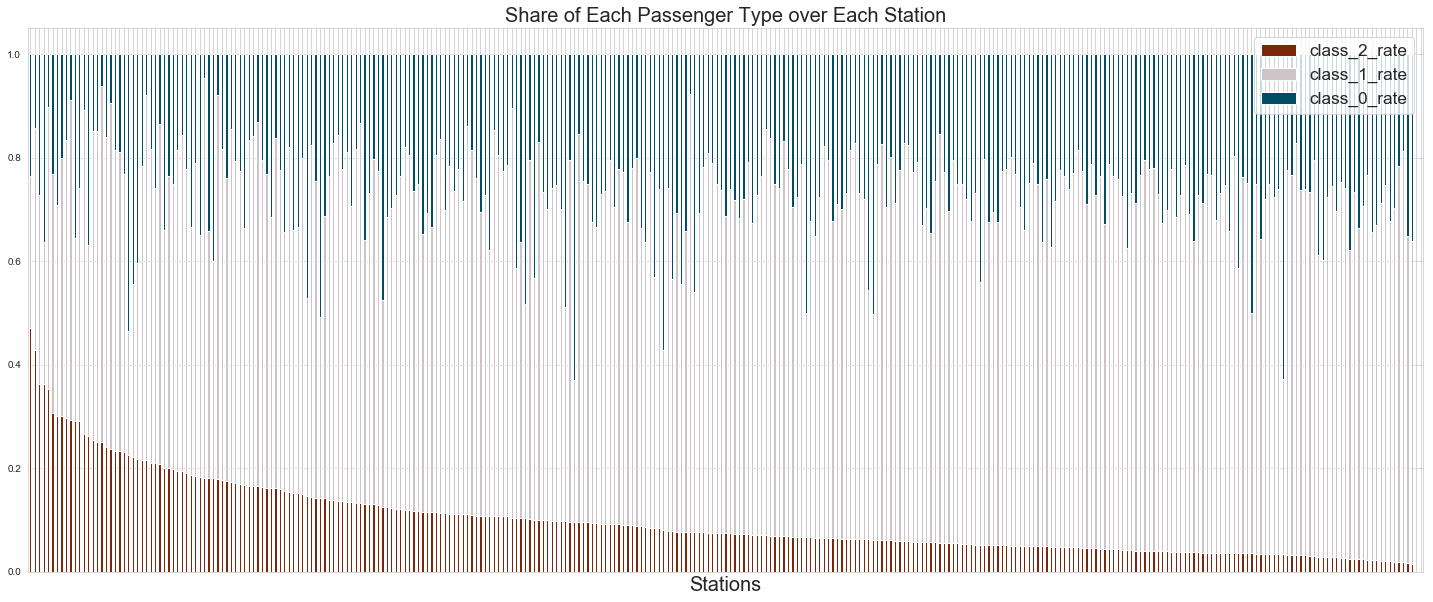

In [27]:
# plot stacked barplot
fig, ax = plt.subplots(1,1,figsize=(25,10))

_ = station_share.plot(y=['class_2_rate', 'class_1_rate', 'class_0_rate'],
                        kind='bar', ax=ax, rot=30, stacked=True,
                        colors=['#7c260b','#cec3c6','#014d64'])
_ = ax.tick_params(labelbottom=False) # remove xtick labels
_ = ax.legend(fontsize='xx-large')
_ = ax.set_title('Share of Each Passenger Type over Each Station', fontsize=20)
_ = ax.set_xlabel(xlabel='Stations', fontsize=20)

## Suggested List of Stations

Finally it comes to answer our question. Which stations are the first choices when planning placing flat leashing ads.

Let's try to take **75% percentile** as the filtering criterion, meaning to select only station which has absolute number of long distance passengers more than **20 people** and the share of long distance passengers higher than **13%**.

In [28]:
# Create a threshold to identify long-distance passengers accounts for over 75% pecentile
# on both the absolute number of passengers and share of passenger type.

station_list = station_share[(station_share['class_2'] >= 20) & (station_share['class_2_rate'] >= 0.13)]
printmd('**In total, {} stations are selected, as follow,**'.format(station_list.shape[0]))
display(station_list)

**In total, 20 stations are selected, as follow,**

,,class_0,class_1,class_2,total,class_0_rate,class_1_rate,class_2_rate
line_y,stop_y,,,,,,,
7,美兰湖,7.00,37.00,24.00,68.00,0.10,0.54,0.35
9,佘山,33.00,46.00,34.00,113.00,0.29,0.41,0.30
6,航津路,6.00,42.00,20.00,68.00,0.09,0.62,0.29
8,沈杜公路,21.00,122.00,52.00,195.00,0.11,0.63,0.27
2,虹桥火车站,123.00,498.00,208.00,829.00,0.15,0.60,0.25
16,惠南,14.00,52.00,21.00,87.00,0.16,0.60,0.24
11,嘉定北,23.00,72.00,29.00,124.00,0.19,0.58,0.23
2,徐泾东,42.00,129.00,52.00,223.00,0.19,0.58,0.23
7,顾村公园,48.00,45.00,26.00,119.00,0.40,0.38,0.22


# Expected Commute Time for each Route

<mark>**User Scenario**</mark><br/>

Assume that passengers saw the ads at the station, and decide to browse on our house leasing website for flat choices. If we were to add on new features in our website, perhaps say, we could provide information of how much travel time required if passengers choose to live in flats around this region. 

Put it more bluntly, users may directly select that s/he wants to arrive at the office before *11am*. Our website can instantly come up with a suggest list of possible locations to search for flats. That's definitely something going to impress the users.

---

<mark>**Brief Summary**</mark><br/>

Before I jump right to compute expected trip time, I will first create flag on different time slot, so that I can dig in further and explore if trip time varies when we take subway at different timing. 

For the scarcity of samples on each route, I will simply create two slots - peak and off-peak hour and explore on it.

Now as usual, first, let's have a look at the distribution of trip time difference between two time slots and then compute the expected commute time.

The **quick conclusion** here is that it seems the time you take subway between peak and off-peak hour doesn't influence the trip time you might spend.

Nonetheless, this is worthy of further investigation to be confirmed. But in my case, the expected commute time just suffices, and no need to segment further on peak and off-peak hours. Finally, in the end of this section, a table of expected commute time will be included as well.

## Flag Peak and Off-Peak Hours

The computation of peak hours is based on the number of exits of all stations over each hour. See the graph down below, it's clear that there are two timing as peak hours - **8:00 and 18:00**. The rest hours have roughly the same amount of traffic.

In [29]:
# Use the destination's datetime as the interval.
route = subway_trip.copy()
route['hour_y'] = route['datetime_y'].apply(lambda x: x.hour)

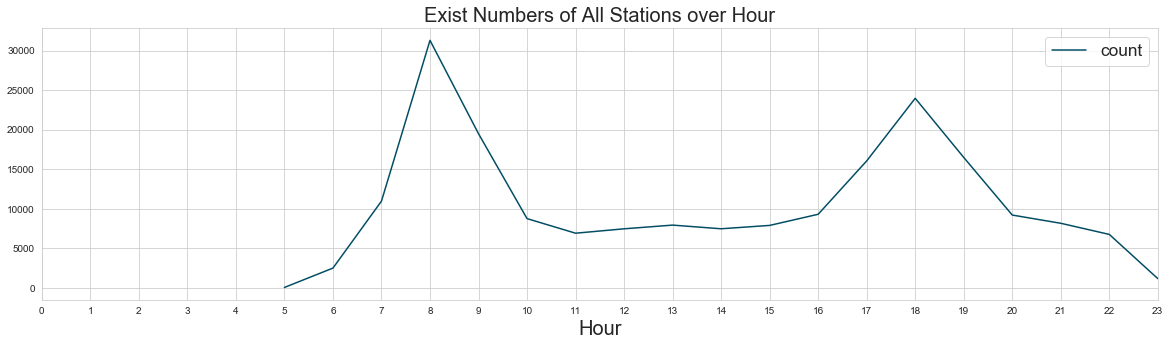

In [30]:
# Plot distribution.
peak = route.groupby(['hour_y']).count(
    )[['transit_card_id_y']].rename(columns={'transit_card_id_y':'count'})

fix, ax = plt.subplots(1,1,figsize=(20,5))

_ = peak.plot(y='count', kind='line', ax=ax, colors=['#014d64'])
_ = ax.set_xticks(ticks=np.arange(24))
_ = ax.legend(fontsize='xx-large')
_ = ax.set_title('Exist Numbers of All Stations over Hour', fontsize=20)
_ = ax.set_xlabel(xlabel='Hour', fontsize=20)

In [31]:
# create flag for peak_hour or off-peak hour
peak_hour = set([8,18])
route['peak_hour'] = route['hour_y'].apply(lambda x: x in peak_hour)

# display(route.head())

## Route's Travel Time between Peak and Off-Peak

In [32]:
# Aggregate up to peak and off-peak interval.
route_peak = route.groupby(['line_x','stop_x','line_y','stop_y','peak_hour']).agg(
    {'trip_length':[('mean', np.mean), ('count', np.size)]})
route_peak.columns = [a + '_' + b for a,b in route_peak.columns.values]
# display(route_peak.head(n=2))

In [33]:
# long to wide
route_peak_wide = route_peak.unstack(level='peak_hour')
cols = route_peak_wide.columns
cols = [str(a).lower() + '_peak_' + str(b).lower() for a,b in cols] 
route_peak_wide.columns = cols
route_peak_wide = route_peak_wide.dropna()
route_peak_wide = route_peak_wide.reset_index()
route_peak_wide['peak_diff'] = route_peak_wide['trip_length_mean_peak_true'] - route_peak_wide['trip_length_mean_peak_false']
print('Check if rows contain missing values:\n')
print(route_peak_wide.isna().any())

printmd('\n**Preview of route_peak_wide:**')
display(route_peak_wide[1:].head(n=5))

Check if rows contain missing values:

line_x                          False
stop_x                          False
line_y                          False
stop_y                          False
trip_length_mean_peak_false     False
trip_length_mean_peak_true      False
trip_length_count_peak_false    False
trip_length_count_peak_true     False
peak_diff                       False
dtype: bool



**Preview of route_peak_wide:**

,line_x,stop_x,line_y,stop_y,trip_length_mean_peak_false,trip_length_mean_peak_true,trip_length_count_peak_false,trip_length_count_peak_true,peak_diff
1,1,上海体育馆,1,上海南站,8.60,9.00,5.00,1.00,0.40
2,1,上海体育馆,1,上海火车站,22.33,26.50,3.00,2.00,4.17
3,1,上海体育馆,1,上海马戏城,33.50,32.00,2.00,1.00,-1.50
4,1,上海体育馆,1,中山北路,28.00,26.00,3.00,1.00,-2.00
5,1,上海体育馆,1,共康路,36.00,40.00,1.00,1.00,4.00


## Distribution of Trip Time Difference on Peak and Off-Peak Hour

**First, delete abnormal routes.** There are some cases where passengers get on and get off at the same station. These records will be excluded from dataset. 

Table below is the statistics of each subway route's commute time. From the table, we can tell that commute time doesn't vary so much between **peak(mean 41 mins)** and **off-peak(mean 40 mins)** hours. Thus, no need to differentiate commute time over different time slot.

*Noted that it is derived from sampled dataset, therefore lots of routes have relative few samples to infer its mean travel time*. That's something to be wary of when interpreting this data.


In [34]:
# Exclude route where get-on and get-off station are the same.
delete_idx = ((route_peak_wide['line_x'] == route_peak_wide['line_y']) & 
              (route_peak_wide['stop_x'] == route_peak_wide['stop_y']))
print('{} abnormal routes are deleted from dataset.'.format(sum(delete_idx)))

route_peak_wide_clean = route_peak_wide[~delete_idx]

237 abnormal routes are deleted from dataset.


In [35]:
printmd('**Descriptive Statistics of Routes on Peak and Off-Peak:**')
display(route_peak_wide_clean.describe())

**Descriptive Statistics of Routes on Peak and Off-Peak:**

,trip_length_mean_peak_false,trip_length_mean_peak_true,trip_length_count_peak_false,trip_length_count_peak_true,peak_diff
count,20157.00,20157.00,20157.00,20157.00,20157.00
mean,41.68,40.01,4.80,2.30,-1.67
std,36.82,39.59,6.61,2.83,46.79
min,1.00,1.00,1.00,1.00,-889.50
25%,24.80,23.60,1.00,1.00,-3.50
50%,36.00,35.00,3.00,1.00,-0.67
75%,50.00,48.50,5.00,3.00,2.00
max,916.00,781.00,118.00,93.00,771.50


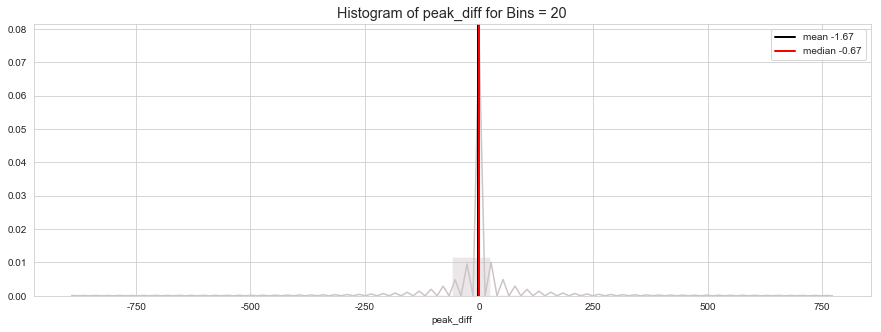

In [36]:
plot_distribution(df=route_peak_wide_clean, col='peak_diff', bins=20)

## Create Table of Mean Commute Time for Each Route

<mark>**User Scenario**</mark><br/>

Below is a preview of final dataset on **mean commute time for each subway route**. It can be used as reference when users are searching for flats within acceptable commute time.

<mark>**Feature Engineering**</mark><br/>

Actually, if we aim at building up a model, **mean commute time of each route** can also serve as a very **informative feature**. Let's say we want to make prediction of the flat's rent, the mean time to commute from the flat to major business district absolutely plays a role.

In [37]:
# Create table of mean commute time for each route.
route_mean = route.groupby(['line_x','stop_x','line_y','stop_y']).agg(
    {'trip_length':[('mean', np.mean), ('count', np.size)]})
route_mean.columns = [a + '_' + b for a,b in route_mean.columns.values]

printmd('**Preview of Table for Mean Commute Time on each Route:**')
route_mean = route_mean.reset_index()
display(route_mean.head())

**Preview of Table for Mean Commute Time on each Route:**

,line_x,stop_x,line_y,stop_y,trip_length_mean,trip_length_count
0,1,上海体育馆,1,上海体育馆,11.40,5
1,1,上海体育馆,1,上海南站,8.67,6
2,1,上海体育馆,1,上海火车站,24.00,5
3,1,上海体育馆,1,上海马戏城,33.00,3
4,1,上海体育馆,1,中山北路,27.50,4


In [38]:
print('Descriptive Statistics of Routes:')
display(route_mean.describe())

Descriptive Statistics of Routes:


,trip_length_mean,trip_length_count
count,52581.00,52581.00
mean,50.86,3.84
std,46.15,6.24
min,0.00,1.00
25%,30.00,1.00
50%,43.50,2.00
75%,61.00,4.00
max,977.00,180.00


## Final Summary on Application Scenario out of this Analysis

Now, let's sum up of what we've known from this data exploration.

<mark>**1. In Terms of Ads Deployemnt**</mark><br/>

In the way of assisting business expansion, my idea is to come up with suggest list of stations to launch ads. Indeed, there're a few stations worth to be considered with its high share of long distance passengers and the traffic volume. 

<mark>**2. In Terms of Feature Add-On for Website**</mark><br/>

What's more better would be in the case, where assuming the passengers saw the ads at the station, and then decide to browse our website. We can not only provide the rent of each flat to them, but also the expected travel time from the your chosen flat to the office. These information all come from the table of mean commute time for each route.

<mark>**3. Reminder of the Suggested Timing to Depart from Home**</mark><br/>

If there is a huge impact on when you depart from home for work. Then our website can inform the user that the expected time required to commute. So that we can suggest the best timing to leave for the office.

# Empower with More Data

<mark>**User Scenario**</mark><br/>

All the discussion so far is focused on how to identify best marketing channel, how to enhance the experience of flat seekers. But the flat leasing company can also provide better service for the **flat posters (landlords)**. One example is to provide proposed rent to new landlords. With proper posted rent, the landlord can lease out the flat more quickly and this in turn, can attract more landlords to post their listing on the website. This will attract more flat seekers again. All these form up a reinforced cycle.

<mark>**Suggested Data**</mark><br/>

In order to accomplish the goal, useful data are in need including, **the posted rent, flat location, size, and equipped amenities etc**. With all these data at hand, we can train a prediction model for any flat. Even on newly developed region, we can assess the flat's price and rent even under the limit of few samples. Following section will sketch out the specification of the predictive model in detail.

# Proposed Model

In the case of predicting rent (numerical variable), there are a lot of models to be chosen from. Common ones include **Regression, Lasso Regression, Decision Tree Regression, and more advanced Neural Network**. Here I will just use the general form of regression to display the idea of how we can build up the predictive model for rent.

$$y = \alpha x_1 + \beta x_2 + \gamma x_3 \dots$$

<mark>**Target Variable:**</mark>
- **`proposed rent`** 

<mark>**Features:**</mark>

<span style='line-height:2.0'>

- **`Flat Attributes`**
    - Can be accessed from website's flat posting data.
    - Such as 1) flat size, 2) amenities, 3) number of rooms 4) age of flat.
- **`Neighborhood`**
    - Can be measured from flat's location on map.
    - Such as 1) distance to supermarket, 2) distance to public transportation. 
- **`Number of Available Flats Nearby`**
    - Can be accessed from website's flat posting data.
    - Such as 1) number of flat posting in the same neighborhood.
- **`Commute Time`**
    - Can be derived from this traffic dataset.
    - Such as 1) mean commute time to major business district.
- **`Population of Neighborhood`**
    - Can be estimated from this traffic dataset.
    - Such as 1) number of residents, either with or without permanent address in that region.

</span>

# Other Application from this Dataset

The dataset we have at hand can actually be applied to other areas as well. Here I will just name two other potential applications leveraging this dataset. One, **metro traffic control** and, the other is **passenger's profiling**.

<mark>**Metro Traffic Control**</mark><br/>

Apart from the absolute traffic volume, the **change rate** of traffic also challenges the ability of metro company to cope with the sudden spike on demand. As we know the **capacity** of each station should be designed to the **peak demand** instead of **mean traffic volume**. Hence, identifying which station has the highest change rate of traffic demand will enable the authority to take proper measures on re-designing the traffic route within these stations and thus, avoiding the case of overcrowds and human stampedes.

<mark>**Passenger's Profiling**</mark><br/>

For long, we've always wanted to build up comprehensive consumer's profiling so that company can provide more suitable service to the end users. In previous attempt, many companies have already build up their consumer profiling based on **their demography, their purchasing behavior, their financial conditions** etc, but few of them ever included the information of **consumer's commute behavior**, or travel path. By covering the travel path of each consumer, we can predict their next location, and push relevant information to them in advance. This is something very technical challenging but possess huge business opportunities.

# Reference

- [tqdm_notebook](https://github.com/tqdm/tqdm/issues/375)
- [tqdm not showing bar](https://stackoverflow.com/questions/48935907/tqdm-not-showing-bar)
- [解决macOS下matplotlib无法显示中文的问题](https://www.jianshu.com/p/8ed59ac76c06)